<a href="https://colab.research.google.com/github/Kprerak-iisc/data-science/blob/master/Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls /content/gdrive/'My Drive/Colab Notebooks/Amazon/data/zip/'

ipykernel_launcher.py_plot.png	train  train_v2.csv


In [ ]:
#libraries
from matplotlib import pyplot
from matplotlib.image import imread
import pandas as pd
from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from pandas import read_csv
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from numpy import load
from numpy import ones
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
 
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model



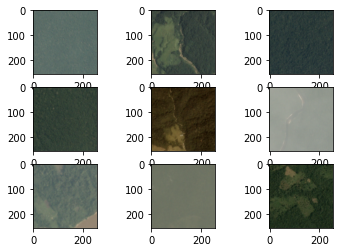

In [ ]:
folder = '/content/gdrive/My Drive/Colab Notebooks/Amazon/data/zip/train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'train_' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

images are satellite photos of the rain forest

In [ ]:
mapping_csv=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Amazon/data/zip/train_v2.csv')
mapping_csv.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [ ]:
all_tags = [item for sublist in list(mapping_csv['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {}'.format(1.0*len(all_tags)/mapping_csv.shape[0]))

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365


In [ ]:
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.head()

,tag,0
12,primary,37513
5,clear,28431
0,agriculture,12315
13,road,8071
16,water,7411


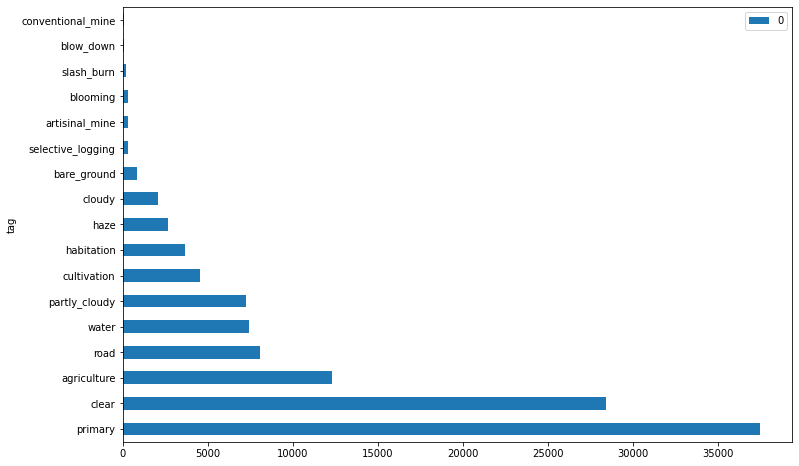

In [ ]:
tags_counted_and_sorted.plot.barh(x='tag', y=0, figsize=(12,8))

develop a target vector for each image with a one hot encoding

In [ ]:
# create a mapping of tags to integers 
def create_tag_mapping(mapping_csv):
	# create a set of all known tags
	labels = set()
	for i in range(len(mapping_csv)):
		tags = mapping_csv['tags'][i].split(' ')
		labels.update(tags)
	labels = list(labels)
	# order set alphabetically
	labels.sort()
	# dict that maps labels to integers, and the reverse
	labels_map = {labels[i]:i for i in range(len(labels))}
	inv_labels_map = {i:labels[i] for i in range(len(labels))}
	return labels_map, inv_labels_map

In [ ]:
#testing the above function
mapping, inv_mapping = create_tag_mapping(mapping_csv)
print(mapping)

{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}


In [ ]:
# create a mapping of filename to tags
def create_file_mapping(mapping_csv):
	mapping = dict()
	for i in range(len(mapping_csv)):
		name, tags = mapping_csv['image_name'][i], mapping_csv['tags'][i]
		mapping[name] = tags.split(' ')
	return mapping

**Loading the JPEG images**

In [ ]:
# create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
	encoding = zeros(len(mapping), dtype='uint8')
	# mark 1 for each tag in the vector
	for tag in tags:
		encoding[mapping[tag]] = 1
	return encoding

In [ ]:
# load all images into memory
def load_dataset(path, file_mapping, tag_mapping):
	photos, targets = list(), list()
	for filename in listdir(folder):
		photo = load_img(path + filename, target_size=(128,128))
		photo = img_to_array(photo, dtype='uint8')
		tags = file_mapping[filename[:-4]]
		# one hot encode tags
		target = one_hot_encode(tags, tag_mapping)
		photos.append(photo)
		targets.append(target)
	X = asarray(photos, dtype='uint8')
	y = asarray(targets, dtype='uint8')
	return X, y

In [ ]:
path = '/content/gdrive/My Drive/Colab Notebooks/Amazon/data/zip/train/'
photos, targets = list(), list()
tag_mapping, _ = create_tag_mapping(mapping_csv)
file_mapping = create_file_mapping(mapping_csv)
for i in range(40479):
  photo=load_img(path + 'train_' + str(i) + '.jpg', target_size=(128,128))
  photo=img_to_array(photo, dtype='uint8')
  tags=file_mapping['train_' + str(i)]
  target=one_hot_encode(tags, tag_mapping)
  photos.append(photo)
  targets.append(target)


KeyboardInterrupt: ignored

The above is not an error. The code was interrupted in between because of memory issue. By that time, 21925 images were loaded. From here onwards we will be working with 21925 image dataset rather than the original 41k images. If one wants to use entire dataset, let the above code run completely.

In [ ]:
X = asarray(photos, dtype='uint8')
y = asarray(targets, dtype='uint8')
print(X.shape, y.shape)

(21925, 128, 128, 3) (21925, 17)


In [ ]:
savez_compressed('/content/gdrive/My Drive/Colab Notebooks/Amazon/data/planet_data.npz', X, y)

In [ ]:
# checking the loaded prepared planet dataset
from numpy import load
data = load('/content/gdrive/My Drive/Colab Notebooks/Amazon/data/planet_data.npz')
X, y = data['arr_0'], data['arr_1']
print('Loaded: ', X.shape, y.shape)

Loaded:  (21925, 128, 128, 3) (21925, 17)


Because of less RAM, we will use only 5000 images in our model

In [ ]:
X1=X[0:5000]
y1=y[0:5000]

In [ ]:
X1.shape,y1.shape

((5000, 128, 128, 3), (5000, 17))

In [ ]:
def load_dataset(X,y):
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

In [ ]:
trainX, trainY, testX, testY = load_dataset(X1,y1)
train_yhat = asarray([ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = asarray([ones(testY.shape[1]) for _ in range(testY.shape[0])])

(4000, 128, 128, 3) (4000, 17) (1000, 128, 128, 3) (1000, 17)


In [ ]:
# evaluate predictions
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')
print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))


All Ones: train=0.482, test=0.483


A version of the F-beta score calculation in Keras to use as a metric:-
A version of this function is also proposed in a Kaggle kernel titled “F-beta score for Keras“

In [ ]:
from keras import backend
 
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

In [ ]:
# evaluate predictions with keras
train_score = fbeta(backend.variable(trainY), backend.variable(train_yhat))
test_score = fbeta(backend.variable(testY), backend.variable(test_yhat))
print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))

All Ones (keras): train=0.482, test=0.483


An all ones prediction for both datasets using keras and sklearn results in a score of about 0.48.This can be used as naive forecast on the test set to which all models in the subsequent sections can be compared to determine if they are skillful or not.

In [ ]:
#Model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(out_shape, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig('/content/gdrive/My Drive/Colab Notebooks/Amazon/data/zip/'+filename + '_plot.png')
	pyplot.close()

In [ ]:
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset(X1,y1)
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow(trainX, trainY, batch_size=128)
	test_it = datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=100, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

(4000, 128, 128, 3) (4000, 17) (1000, 128, 128, 3) (1000, 17)
> loss=0.178, fbeta=0.750


Fbeta score increases from 0.48 to 0.75

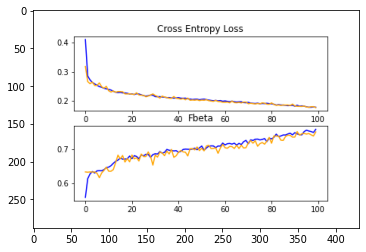

In [ ]:
import imageio
import glob

im = imageio.imread("/content/gdrive/My Drive/Colab Notebooks/Amazon/data/zip/ipykernel_launcher.py_plot.png")
pyplot.imshow(im)

**Use Image Augmentation for improving performance**

In [ ]:
def run_test_harness():
	trainX, trainY, testX, testY = load_dataset(X1,y1)
	# create data generator with image augmentation
	train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow(trainX, trainY, batch_size=128)
	test_it = test_datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=200, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)

run_test_harness()

(4000, 128, 128, 3) (4000, 17) (1000, 128, 128, 3) (1000, 17)
> loss=0.160, fbeta=0.800


fbeta score further increases to 0.8

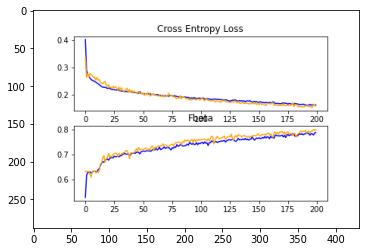

In [ ]:
im = imageio.imread("/content/gdrive/My Drive/Colab Notebooks/Amazon/data/zip/ipykernel_launcher.py_plot.png")
pyplot.imshow(im)

Additional image augmentations that may further encourage the learning of features invariant to their position in the input, such as zooms and shifts can be used to improve the performance.
Addition of regularization techniques slows the progression of the learning algorithms and reduces overfitting, resulting in improved performance on the holdout dataset

**Using Transfer Learning**

 Using the VGG-16 model

In [ ]:
def define_model(in_shape=(128, 128, 3), out_shape=17):
	# load model
	model = VGG16(include_top=False, input_shape=in_shape)
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(out_shape, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model

In the above model, the classifier part of the model can be removed automatically by setting the “include_top” argument to “False“.
The VGG16 model was trained on a specific ImageNet challenge dataset. As such, the model expects images to be centered.
we can achieve the same effect with the image data generator, by setting the “featurewise_center” argument to “True” and manually specifying the mean pixel values to use when centering as the mean values from the ImageNet training dataset: [123.68, 116.779, 103.939].

In [ ]:
def run_test_harness():
	trainX, trainY, testX, testY = load_dataset(X1,y1)
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterators
	train_it = datagen.flow(trainX, trainY, batch_size=128)
	test_it = datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)
 

run_test_harness()

(4000, 128, 128, 3) (4000, 17) (1000, 128, 128, 3) (1000, 17)
> loss=0.183, fbeta=0.837


fbeta further increases to 0.837.
Note: We are only using 4k images in our training set.
This fbeta score is quite acceptable considering this.

In [ ]:
x=define_model()
x.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)      

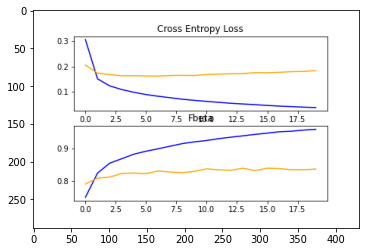

In [ ]:
im = imageio.imread("/content/gdrive/My Drive/Colab Notebooks/Amazon/data/zip/ipykernel_launcher.py_plot.png")
pyplot.imshow(im)

model fits the dataset quickly, showing strong overfitting within just a few training epochs.
It seems that regularization can make it better and increasig the number of epochs to give more time to the model to converge.

In [ ]:
def define_model(in_shape=(128, 128, 3), out_shape=17):
	# load model
	model = VGG16(include_top=False, input_shape=in_shape)
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# allow last vgg block to be trainable
	model.get_layer('block5_conv1').trainable = True
	model.get_layer('block5_conv2').trainable = True
	model.get_layer('block5_conv3').trainable = True
	model.get_layer('block5_pool').trainable = True
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(out_shape, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model

Using Image Augmentation to reduce overfitting

In [ ]:
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset(X1,y1)
	# create data generator
	train_datagen = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
	test_datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	train_datagen.mean = [123.68, 116.779, 103.939]
	test_datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterators
	train_it = train_datagen.flow(trainX, trainY, batch_size=128)
	test_it = test_datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

(4000, 128, 128, 3) (4000, 17) (1000, 128, 128, 3) (1000, 17)
> loss=0.129, fbeta=0.886


fbeta score further improves to 0.886 which is great considering we only have 4k images in our training set.

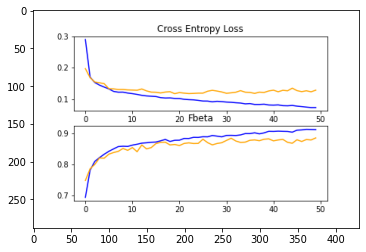

In [ ]:
im = imageio.imread("/content/gdrive/My Drive/Colab Notebooks/Amazon/data/zip/ipykernel_launcher.py_plot.png")
pyplot.imshow(im)

The plot seems to generalize well to our holdout dataset which means our model is not overfitting.
Further improvements can be done by trying different optimizer function and learning rate or by using using another prtrained model like Resnet which is a bigger model compare to VGG16.For now, I blieve, this model suffices our objective

**Saving Final Model**

 We fit our final model on the entire training dataset and validation set.

In [ ]:
def define_model(in_shape=(128, 128, 3), out_shape=17):
	# load model
	model = VGG16(include_top=False, input_shape=in_shape)
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# allow last vgg block to be trainable
	model.get_layer('block5_conv1').trainable = True
	model.get_layer('block5_conv2').trainable = True
	model.get_layer('block5_conv3').trainable = True
	model.get_layer('block5_pool').trainable = True
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(out_shape, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy')
	return model
 
# run the test harness for evaluating a model
def run_test_harness():
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow(X1, y1, batch_size=128)
	# define model
	model = define_model()
	# fit model
	model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=50, verbose=0)
	# save model
	model.save('/content/gdrive/My Drive/Colab Notebooks/Amazon/data/zip/final_model.h5')
 
# entry point, run the test harness
run_test_harness()

Making prediction

In [ ]:
from keras.models import load_model

We used only first 5000 images for model development and validation. We can test our model on any image from 5001 index to 21925.


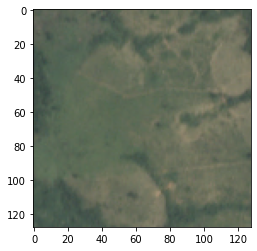

In [ ]:
pyplot.imshow(X[-4])

Let's check on this unseen image

In [ ]:
y[-4]

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], dtype=uint8)

Actual labels belonging to this image are:
'agriculture', 'clear', 'primary' , 'road'

In [ ]:
def prediction_to_tags(inv_mapping, prediction):
	# round probabilities to {0, 1}
	values = prediction.round()
	# collect all predicted tags
	tags = [inv_mapping[i] for i in range(len(values)) if values[i] == 1.0]
	return tags

In [ ]:
img=X[-4]
img = img.reshape(1, 128, 128, 3)
	# center pixel data
img = img.astype('float32')
img = img - [123.68, 116.779, 103.939]

In [ ]:
def run_example(inv_mapping):
	# load model
	model = load_model('/content/gdrive/My Drive/Colab Notebooks/Amazon/data/zip/final_model.h5')
	# predict the class
	result = model.predict(img)
	print(result[0])
	# map prediction to tags
	tags = prediction_to_tags(inv_mapping, result[0])
	print(tags)

In [ ]:
_, inv_mapping = create_tag_mapping(mapping_csv)
run_example(inv_mapping)

[9.9930668e-01 1.0191542e-06 3.3153896e-04 6.3083030e-06 9.3666007e-05
 9.9676067e-01 1.8610920e-07 3.2059331e-06 8.0312230e-02 2.4642719e-02
 3.2974317e-04 3.7838037e-03 9.8413438e-01 9.3053013e-01 3.1027703e-08
 4.7720090e-04 1.0372905e-01]
['agriculture', 'clear', 'primary', 'road']


Further Improvements possible:
Tuning Learning Rate, addition of regularization techniques to the transfer learning such as early stopping,weight decay.

Predicted tags are : 'agriculture', 'clear', 'primary', 'road' which are same as actual.